In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math
from quantile_forest import RandomForestQuantileRegressor
from benchmark_pipeline import read_features

# df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)
output_folder = '/mnt/primus/xuemeng_tmp_harbour/soc/results'

In [2]:
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

def quantile_cross_val_predict(estimator, X, y, cv, quantiles, groups=None):
    """ Custom cross-validation to handle quantile predictions with group support. """
    predictions = {q: [] for q in quantiles}
    if groups is None:
        cv_split = cv.split(X)
    else:
        cv_split = cv.split(X, y, groups)
    
    for train_idx, test_idx in cv_split:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        
        # Fit the model on the training data
        estimator.fit(X_train, y_train)
        
        # Predict each quantile and store results
        for q in quantiles:
            pred = estimator.predict(X_test, quantiles=q)
            predictions[q].extend(pred)
    
    return predictions

In [3]:
# a = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/', 'model_rf.*.ccc.joblib')
# a = [str(i) for i in a]
best_dfff = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc/results/benchmark_metrics_predictions.csv',low_memory=False)

prop_list = ['oc','ph_h2o','ph_cacl2','bulk_density','caco3','CEC','EC','P','K','N']
path_list = []
covs_list = []
for prop in prop_list:
    covs_list.append(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/benchmark_selected.covs_{prop}.txt')
    
    a = find_files(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/','*model*joblib')
    a = [str(i) for i in a]
    model_t = best_dfff.loc[best_dfff['property']==prop,'title'].values[0]
    
    if 'weighted' in model_t:
        model_t = model_t.split('_')[0]
        a = [ii for ii in a if 'weighted' in ii]
    else:
        a = [ii for ii in a if 'weighted' not in ii]

    for ia in a:
        if model_t in ia:
            path_list.append(ia)

In [4]:
path_list

['/mnt/primus/xuemeng_tmp_harbour/soc/results/oc/model_rf.oc_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_h2o/model_rf.ph_h2o_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_cacl2/model_rf.ph_cacl2_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/bulk_density/model_rf.bulk_density_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/caco3/model_rf.caco3_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/CEC/model_rf.CEC_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/EC/model_rf.EC_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/P/model_rf.P_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/K/model_rf.K_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_rf.N_log1p.ccc.joblib']

In [5]:
quantiles = [0.05,0.95]
results = []
cv = GroupKFold(n_splits=5)  
spatial_cv_column = 'tile_id'

import warnings
warnings.filterwarnings('ignore', message="X has feature names, but RandomForestQuantileRegressor was fitted without feature names")

for prop in prop_list:
    test = pd.read_csv(f'{output_folder}/{prop}/benchmark_test.pnts_{prop}.csv',low_memory=False)
    train = pd.read_csv(f'{output_folder}/{prop}/benchmark_train.pnts_{prop}.csv',low_memory=False)

    covs = read_features(f'{output_folder}/{prop}/benchmark_selected.covs_{prop}.txt')
    
    train = train.dropna(subset=covs,how='any')
    test = test.dropna(subset=covs,how='any')
    
    for i in path_list:
        if prop in i:
            file_rf = i
            
    rf_model = joblib.load(file_rf)
    params = rf_model.get_params()
    params['n_jobs'] = 90
    qrf = RandomForestQuantileRegressor(**params)
    
    ttprint(f'quantile, cv, {prop}')
    # cv valiadate
    # y_pred_cv_rf = cross_val_predict(rf_model, train[covs], train[prop], cv=cv, n_jobs=-1)
    start_time = time.time()
    predictions = quantile_cross_val_predict(qrf, train[covs], train[prop], cv, quantiles, groups = train[spatial_cv_column])
    end_time = time.time()
    cv_time = (end_time - start_time)
    picp_cv = calc_picp(np.array(predictions[quantiles[0]]), np.array(predictions[quantiles[1]]), train[prop])
    
    qcp_cv_lower = calc_qcp(np.array(predictions[quantiles[0]]), train[prop], quantiles[0])
    qcp_cv_upper = calc_qcp(np.array(predictions[quantiles[1]]), train[prop], quantiles[1])
    
    piw_cv = np.mean(np.array(predictions[quantiles[1]])-np.array(predictions[quantiles[0]]))
    
    
    # individual test data
    ttprint(f'quantile, individual test, {prop}')
    qrf.fit(train[covs], train[prop])
    start_time = time.time()
    y_pred_test = qrf.predict(test[covs], quantiles=quantiles)
    end_time = time.time()
    test_time = (end_time - start_time)
    picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[prop])
    
    qcp_test_lower = calc_qcp(y_pred_test[:,0], test[prop], quantiles[0])
    qcp_test_upper = calc_qcp(y_pred_test[:,1], test[prop], quantiles[1])
    
    piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])
    
    results.append({
            'property': prop,
            'picp_val': picp_test,
            'piw_val': piw_test,
            'qcp05_val': qcp_test_lower,
            'qcp95_val': qcp_test_upper,
            'picp_cv': picp_cv,
            'piw_cv': piw_cv,
            'qcp05_cv': qcp_cv_lower,
            'qcp95_cv': qcp_cv_upper,
            'time_cv': cv_time,
            'time_val': test_time
        })
    
results = pd.DataFrame(results)
results.to_csv(f'{output_folder}/benchmark_metrics_quantiles.csv',index=False)

[12:11:12] quantile, cv, oc
[12:13:49] quantile, individual test, oc
[12:14:34] quantile, cv, ph_h2o
[12:16:02] quantile, individual test, ph_h2o
[12:16:29] quantile, cv, ph_cacl2
[12:18:16] quantile, individual test, ph_cacl2
[12:18:45] quantile, cv, bulk_density
[12:19:07] quantile, individual test, bulk_density
[12:19:16] quantile, cv, caco3
[12:20:01] quantile, individual test, caco3
[12:20:13] quantile, cv, CEC
[12:20:38] quantile, individual test, CEC
[12:20:48] quantile, cv, EC
[12:21:41] quantile, individual test, EC
[12:21:59] quantile, cv, P
[12:23:04] quantile, individual test, P
[12:23:25] quantile, cv, K
[12:25:13] quantile, individual test, K
[12:25:44] quantile, cv, N
[12:27:39] quantile, individual test, N


In [6]:
results

,property,picp_val,piw_val,qcp05_val,qcp95_val,picp_cv,piw_cv,qcp05_cv,qcp95_cv,time_cv,time_val
0,oc,0.911758,113.206784,0.046327,0.957423,0.591396,120.629154,0.203107,0.794312,157.083848,0.140692
1,ph_h2o,0.913485,2.226528,0.038623,0.951666,0.559263,2.494761,0.219349,0.777880,88.715131,0.115226
2,ph_cacl2,0.919444,2.241726,0.039726,0.955418,0.570093,2.595909,0.217648,0.785499,106.924424,0.119765
3,bulk_density,0.908785,0.848127,0.046087,0.954873,0.633553,0.821331,0.187298,0.820332,21.681113,0.096607
4,caco3,0.957399,198.416792,0.341568,0.958659,0.768095,200.030726,0.384996,0.833864,45.658252,0.092724
5,CEC,0.921088,32.826902,0.043103,0.954244,0.777920,37.444468,0.121604,0.896680,24.661894,0.095304
6,EC,0.902681,54.627100,0.044356,0.947037,0.695425,54.497298,0.165878,0.861280,53.068233,0.100602
7,P,0.935691,72.644469,0.094586,0.947403,0.800309,76.694634,0.138710,0.911262,64.963063,0.113046
8,K,0.898939,423.682229,0.046440,0.945378,0.765266,441.400851,0.134051,0.899281,107.763447,0.113612
9,N,0.922484,8.332410,0.051971,0.959260,0.586770,13.178725,0.209805,0.789534,114.441996,0.123646


### Train the production model

In [7]:
# load all the data
df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)

In [14]:
prop = 'oc'
dff = df.dropna(subset=[prop],how='any')
dff = dff.loc[dff[f'{prop}_qa']>5]

In [15]:
dff

,id,lat,lon,time,ref,nuts0,oc,ph_h2o,ph_cacl2,bulk_density,...,lithology_EGDI_syenite,lithology_EGDI_tephrite,lithology_EGDI_tonalite,lithology_EGDI_trachyte,lithology_EGDI_trachytoid,lithology_EGDI_tuffBrecciaAgglomerateOrPyroclasticBreccia,lithology_EGDI_ultramaficIgneousRock,lithology_EGDI_wacke,lithology_EGDI_Unpopulated,hzn_dep
0,1-1,40.871480,-7.049093,2000.0,portugal.infosolo,PT,6.7,5.2,NaN,NaN,...,0,0,0,0,0,0,0,0,0,15.0
1,1-2,40.871480,-7.049093,2000.0,portugal.infosolo,PT,3.9,5.5,NaN,NaN,...,0,0,0,0,0,0,0,0,0,42.5
2,2-3,40.583860,-6.952317,2000.0,portugal.infosolo,PT,5.9,4.9,NaN,NaN,...,0,0,0,0,0,0,0,0,0,6.5
3,2-4,40.583860,-6.952317,2000.0,portugal.infosolo,PT,6.2,5.2,NaN,NaN,...,0,0,0,0,0,0,0,0,0,25.5
4,3-5,40.756090,-6.862586,2000.0,portugal.infosolo,PT,5.4,5.4,NaN,NaN,...,0,0,0,0,0,0,0,0,0,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390106,P0000739358,58.701308,26.593805,2021.0,estonia.kese,EE,20.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,10.0
390107,P0000739254,58.701377,26.594116,2021.0,estonia.kese,EE,20.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,10.0
390108,P0000739334,58.701446,26.594428,2021.0,estonia.kese,EE,20.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,10.0
390113,P0000739268,58.936527,23.692333,2021.0,estonia.kese,EE,30.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,10.0


In [8]:
import shutil
from scipy.stats import norm, shapiro, kstest

n_jobs=90
results = []
for ii in range(len(covs_list)):
    
    # target property
    prop = prop_list[ii]
    print(f'process {prop}')
    
    # model
    model = joblib.load(path_list[ii])
    namef = 'propduction.quantile.' + path_list[ii].split('/')[-1]
    
    # covariates
    covs = read_features(covs_list[ii])
    
    # all the data
    dff = df.dropna(subset=covs+[prop],how='any')
    dff = dff.loc[dff[f'{prop}_qa']>5]
    
    # update model's n_jobs
    params = model.get_params()
    params['n_jobs'] = 90
    qrf = RandomForestQuantileRegressor(**params)
    
    # fit the model
    qrf.fit(dff[covs], dff[prop])
    joblib.dump(qrf,f'/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/{namef}')
    # shutil.copy(covs_list[ii], covs_list[ii].replace(f'results/{prop}','results/production_model'))
    
    # calculate stats
    shapiro_test = shapiro(dff[prop])
    ks_test = kstest(dff[prop], 'norm', args=(dff[prop].mean(), dff[prop].std()))
    
    # Determine if the data passes the normality tests
    shapiro_pass = shapiro_test.pvalue > 0.05
    ks_pass = ks_test.pvalue > 0.05

    mean_value = dff[prop].mean()
    p0_025 = np.percentile(dff[prop], 2.5)
    p0_075 = np.percentile(dff[prop], 97.5)

    results.append({
            'property': prop,
            'mean': mean_value,
            'p025': p0_025,
            'p975': p0_075,
            'shapiro_test': shapiro_test,
            'ks_test': ks_test,
            'shapiro_pass': shapiro_pass,
            'ks_pass': ks_pass

        })

process oc


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process ph_h2o


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process ph_cacl2


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process bulk_density


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process caco3


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process CEC


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process EC


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process P


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process K


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process N


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
import shutil
from scipy.stats import norm, shapiro, kstest

n_jobs=90
for ii in range(len(covs_list)):
    
    # target property
    prop = prop_list[ii]
    print(f'process {prop}')
    # all the data
    dff = df.dropna(subset=covs+[prop],how='any')
    dff = dff.loc[dff[f'{prop}_qa']>5]
    dff[prop + '_log1p'] = np.log1p(dff[prop])
    prop = prop + '_log1p'
    
    # calculate stats
    shapiro_test = shapiro(dff[prop])
    ks_test = kstest(dff[prop], 'norm', args=(dff[prop].mean(), dff[prop].std()))
    
    # Determine if the data passes the normality tests
    shapiro_pass = shapiro_test.pvalue > 0.05
    ks_pass = ks_test.pvalue > 0.05

    mean_value = dff[prop].mean()
    p0_025 = np.percentile(dff[prop], 2.5)
    p0_075 = np.percentile(dff[prop], 97.5)

    results.append({
            'property': prop,
            'mean': mean_value,
            'p025': p0_025,
            'p975': p0_075,
            'shapiro_test': shapiro_test,
            'ks_test': ks_test,
            'shapiro_pass': shapiro_pass,
            'ks_pass': ks_pass

        })

process oc


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process ph_h2o


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process ph_cacl2


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process bulk_density
process caco3


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process CEC
process EC


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process P


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process K


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


process N


/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [11]:
results = pd.DataFrame(results)
# results.to_csv('',index=False)
results.to_csv(f'{output_folder}/benchmark_normal.test.csv',index=False)

In [12]:

results

,property,mean,p025,p975,shapiro_test,ks_test,shapiro_pass,ks_pass
0,oc,42.943196,1.379860,344.320000,"(0.46182781457901, 0.0)","(0.29452477363592877, 0.0)",False,False
1,ph_h2o,6.270665,4.010000,8.240000,"(0.9653780460357666, 0.0)","(0.06738574382254414, 0.0)",False,False
2,ph_cacl2,5.782887,3.300000,7.620000,"(0.9478154182434082, 0.0)","(0.0936653389437958, 0.0)",False,False
3,bulk_density,1.233236,0.192000,1.760000,"(0.844904899597168, 0.0)","(0.08737098632105922, 1.7556096334484177e-223)",False,False
4,caco3,58.187248,0.000000,500.000000,"(0.504503607749939, 0.0)","(0.3609496912643789, 0.0)",False,False
5,CEC,17.482873,2.000000,52.400000,"(0.5173435211181641, 0.0)","(0.19382153236456479, 0.0)",False,False
6,EC,20.827214,2.150000,84.400000,"(0.2369210124015808, 0.0)","(0.3457942425383249, 0.0)",False,False
7,P,30.308359,0.000000,103.500000,"(0.7042587399482727, 0.0)","(0.1671502642562176, 0.0)",False,False
8,K,191.651756,21.000000,654.930000,"(0.5755832195281982, 0.0)","(0.1915421587761711, 0.0)",False,False
9,N,6.934759,0.150000,28.460000,"(0.17883485555648804, 0.0)","(0.41060429608228305, 0.0)",False,False


In [16]:
dff = df.loc[df['oc_qa']>5]

<Axes: >

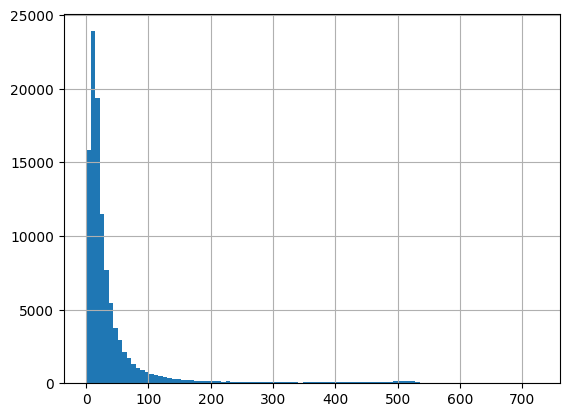

In [17]:
dff['oc'].hist(bins=100)

/tmp/ipykernel_429599/677896108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['oc_log1p'] = np.log1p(dff['oc'])


<Axes: >

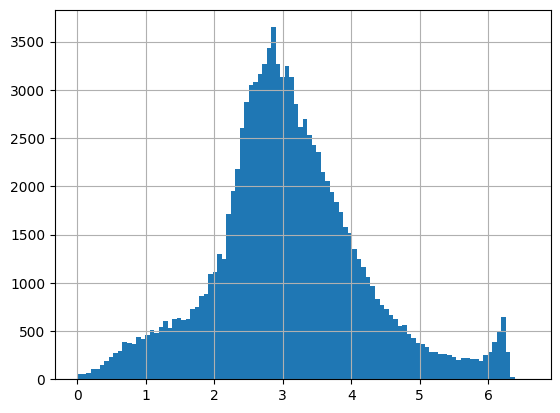

In [18]:
dff['oc_log1p'] = np.log1p(dff['oc'])
dff['oc_log1p'].hist(bins=100)

### Example of input and output

In [20]:
y_pred_test = qrf.predict(test[covs], quantiles=quantiles)
# qrf: the quantile random forest model
# test[covs]: covariates to be predicted
# quantiles: quantiles that we are interested

In [18]:
quantiles  # we are interested in quantile 0.05 and 0.95

[0.05, 0.95]

In [15]:
test[covs].shape  
# 4541 points to be predicted
# 23 covariates

(4541, 23)

In [16]:
y_pred_test.shape  
# 4541 predicted quantiles:
# (:,0) is for quantile 0.05
# (:,1) is for quantile 0.95

(4541, 2)